In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk
import numpy as np
import warnings
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw')
nltk.download('punkt')  # Downloading NLTK tokenizer data
#pip install --upgrade keras
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ejaza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ejaza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw to
[nltk_data]     C:\Users\ejaza\AppData\Roaming\nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ejaza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
pip install transformers tensorflow keras

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [5]:
data_original = open(r'C:\Users\ejaza\Downloads\complaints.json')

In [6]:
raw_data=json.load(data_original)

In [7]:
df = pd.DataFrame(raw_data['data'])

In [8]:
df

,text,complaint_id
0,I recently opened a Citibank CitiGold Checking...,bc_5
1,I went into Capital One bank to open a checkin...,bc_3
2,I try using my chase card at a bakery departme...,bc_2
3,Approximately a half hour ago I visited a US B...,bc_2
4,I have made a transaction using Chase quickpay...,bc_6
...,...,...
395,I am struggling to get the debt relief I am en...,lc_1
396,I turn in the car in 2010 as a voluntary repos...,lc_0
397,We set up payment for interest payment only fo...,lc_1
398,This regards a car loan financed by First Hawa...,lc_0


In [9]:
df['text'][0]

'I recently opened a Citibank CitiGold Checking Account that was advertised to have a signup bonus of   AAdvantage points upon the completion of two consecutive bill payments and {$1000.00} in debit card purchases. After signing up with the intent to complete these requirements a Citibank representative confirmed that the offer applied to my new account and that I should complete the offer requirements. This confirmation was communicated via their online secure message feature, and I have attached a copy for reference. Once I completed the requirements as directed I inquired about the expected delivery date of the earned bonus via secure message and I was told that my account was not targeted and that I would not receive the bonus as promised. This conflicts with what I was previously told and I have already spent a considerable amount of time to meet the requirements as directed. '

In [10]:
#missing values
df.isnull().sum()

text            0
complaint_id    0
dtype: int64

### 1.	Data Understanding: 
A. Find out how many labelled customer complaints are in the data

In [11]:
df.head()

,text,complaint_id
0,I recently opened a Citibank CitiGold Checking...,bc_5
1,I went into Capital One bank to open a checkin...,bc_3
2,I try using my chase card at a bakery departme...,bc_2
3,Approximately a half hour ago I visited a US B...,bc_2
4,I have made a transaction using Chase quickpay...,bc_6


In [12]:
# Option 1 - looping
labeled_complaints_count = sum('complaint_id' in df for text in df['complaint_id'])

print(f'Total number of labeled customer complaints = {labeled_complaints_count}')

Total number of labeled customer complaints = 400


In [13]:
#option 2 - lenght
total_complaints = len(df)
total_complaints

400

### 1.	Data Understanding:
B. Find out the relative frequency of tags in the dataset ... Count the occurrences of each complaint_id

In [14]:
complaint_counts = df['complaint_id'].value_counts()
relative_frequencies = complaint_counts / total_complaints
# Print the results
for complaint_id, frequency in relative_frequencies.items():
    print(f'{complaint_id}: {frequency:.2%}')

lc_1: 14.00%
lc_0: 10.75%
bc_5: 6.25%
mc_1: 6.25%
mc_3: 6.00%
bc_2: 5.50%
bc_0: 5.00%
mc_4: 5.00%
mc_0: 4.25%
cc_2: 4.25%
cc_0: 3.75%
bc_4: 3.75%
cc_13: 3.75%
mc_2: 3.50%
cc_15: 3.25%
cc_8: 3.00%
bc_3: 1.75%
bc_6: 1.75%
cc_4: 1.50%
cc_1: 1.50%
bc_1: 1.00%
cc_5: 0.75%
cc_10: 0.50%
cc_3: 0.50%
cc_12: 0.50%
cc_7: 0.50%
cc_9: 0.50%
cc_11: 0.25%
cc_6: 0.25%
cc_14: 0.25%
lc_2: 0.25%


### Option 2

In [15]:
# Calculate the relative frequency
relative_frequencies = df['complaint_id'].value_counts(normalize=True)

# Print the results
print("Relative Frequencies:")
print(relative_frequencies)

Relative Frequencies:
lc_1     0.1400
lc_0     0.1075
bc_5     0.0625
mc_1     0.0625
mc_3     0.0600
bc_2     0.0550
bc_0     0.0500
mc_4     0.0500
mc_0     0.0425
cc_2     0.0425
cc_0     0.0375
bc_4     0.0375
cc_13    0.0375
mc_2     0.0350
cc_15    0.0325
cc_8     0.0300
bc_3     0.0175
bc_6     0.0175
cc_4     0.0150
cc_1     0.0150
bc_1     0.0100
cc_5     0.0075
cc_10    0.0050
cc_3     0.0050
cc_12    0.0050
cc_7     0.0050
cc_9     0.0050
cc_11    0.0025
cc_6     0.0025
cc_14    0.0025
lc_2     0.0025
Name: complaint_id, dtype: float64


### 1.	Data Understanding:
C. Check if there are any encoding issues (try to read the data using open() and see if you need to use any special text encoding options, other than utf-8)

In [16]:
filename = r'C:\Users\ejaza\Downloads\complaints.json'

# List of encodings to try
encodings_to_try = ['utf-8', 'ISO-8859-1', 'latin-1', 'utf-16', 'utf-32']

# Try reading the file with different encodings
for encoding in encodings_to_try:
    try:
        with open(filename, 'r', encoding=encoding) as file:
            content = file.read()
        print(f"Successfully read file with encoding: {encoding}")
        #break  # Stop trying if successful
    except UnicodeDecodeError:
        print(f"Failed to read with encoding: {encoding}")

Successfully read file with encoding: utf-8
Successfully read file with encoding: ISO-8859-1
Successfully read file with encoding: latin-1
Failed to read with encoding: utf-16
Failed to read with encoding: utf-32


### 1. Data Understanding:
D. Create a report that identifies how much of each complaint is composed of commonly used english stopwords.

In [17]:
#import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

In [18]:
# Download the stopwords dataset if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Function to calculate the percentage of stopwords in a text
def calculate_stopword_percentage(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    stopword_count = sum(1 for word in words if word in stop_words)
    total_words = len(words)
    return (stopword_count / total_words) * 100 if total_words > 0 else 0

# Apply the function to each complaint text in the DataFrame
df['stopword_percentage'] = df['text'].apply(calculate_stopword_percentage)

# Print the results
print("Stopword Percentage Report:")
print(df[['complaint_id', 'stopword_percentage']].to_string(index=False, float_format="%.2f"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ejaza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ejaza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Stopword Percentage Report:
complaint_id  stopword_percentage
        bc_5                45.81
        bc_3                42.47
        bc_2                43.78
        bc_2                45.85
        bc_6                45.00
        bc_0                44.44
        bc_0                51.89
        bc_5                54.90
        bc_5                46.91
        bc_0                47.60
        bc_6                39.49
        bc_2                52.22
        bc_4                51.76
        bc_2                47.52
        bc_5                42.60
        bc_2                48.33
        bc_2                60.10
        bc_0                41.91
        bc_6                46.15
        bc_2                42.49
        bc_5                45.90
        bc_2                46.85
        bc_4                47.75
        bc_4                50.79
        bc_2                39.77
        bc_6                52.12
        bc_2                42.77
        bc_4        

In [19]:
# print with a % sign, did not woprk with adding a % in the above
print(df.apply(lambda row: f"{row['complaint_id']}: {row['stopword_percentage']:.2f}%", axis=1))

0      bc_5: 45.81%
1      bc_3: 42.47%
2      bc_2: 43.78%
3      bc_2: 45.85%
4      bc_6: 45.00%
           ...     
395    lc_1: 45.71%
396    lc_0: 52.34%
397    lc_1: 48.81%
398    lc_0: 49.37%
399    lc_0: 48.15%
Length: 400, dtype: object


In [ ]:
# Printing without the index
print(df[['complaint_id', 'stopword_percentage']].to_string(index=False, col_space=20, float_format="%.2f") + " %")

In [20]:
# Print the results with headers, two decimal places, and the '%' symbol
report = df[['complaint_id', 'stopword_percentage']].to_string(index=False, float_format="%.2f")
print("Stopword Percentage Report:")
print(report.replace('\n', ' %\n') + ' %')

Stopword Percentage Report:
complaint_id  stopword_percentage %
        bc_5                45.81 %
        bc_3                42.47 %
        bc_2                43.78 %
        bc_2                45.85 %
        bc_6                45.00 %
        bc_0                44.44 %
        bc_0                51.89 %
        bc_5                54.90 %
        bc_5                46.91 %
        bc_0                47.60 %
        bc_6                39.49 %
        bc_2                52.22 %
        bc_4                51.76 %
        bc_2                47.52 %
        bc_5                42.60 %
        bc_2                48.33 %
        bc_2                60.10 %
        bc_0                41.91 %
        bc_6                46.15 %
        bc_2                42.49 %
        bc_5                45.90 %
        bc_2                46.85 %
        bc_4                47.75 %
        bc_4                50.79 %
        bc_2                39.77 %
        bc_6                52.12 %


In [21]:
# Apply the function to each complaint text in the DataFrame
df['stopword_percentage'] = df['text'].apply(calculate_stopword_percentage)

### Q1. Data Understanding:
C. Create a report that identifies how much of each complaint is composed of commonly used english stopwords.
### in Graphs and added to data set

In [22]:
df.head()

,text,complaint_id,stopword_percentage
0,I recently opened a Citibank CitiGold Checking...,bc_5,45.806452
1,I went into Capital One bank to open a checkin...,bc_3,42.465753
2,I try using my chase card at a bakery departme...,bc_2,43.783784
3,Approximately a half hour ago I visited a US B...,bc_2,45.853659
4,I have made a transaction using Chase quickpay...,bc_6,45.000000


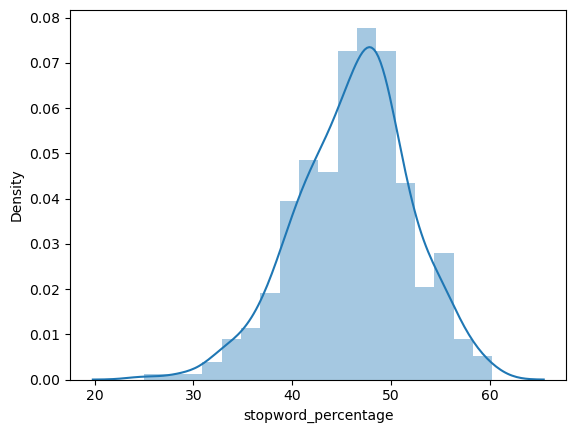

In [23]:
sns.distplot(df['stopword_percentage']);

# If percentage of stopwords in text is:
    # <= 35% ------ labeled as Low
    # >35% but <= 40% ------ labeled as Medium
    # stp% > 40% ------ labeled as High

In [24]:
bins = [0,35,40,100]
labels = ['Low','Medium','High']

df['labels'] = pd.cut(df['stopword_percentage'],bins = bins,labels = labels,include_lowest= True)

In [25]:
df.head()

,text,complaint_id,stopword_percentage,labels
0,I recently opened a Citibank CitiGold Checking...,bc_5,45.806452,High
1,I went into Capital One bank to open a checkin...,bc_3,42.465753,High
2,I try using my chase card at a bakery departme...,bc_2,43.783784,High
3,Approximately a half hour ago I visited a US B...,bc_2,45.853659,High
4,I have made a transaction using Chase quickpay...,bc_6,45.000000,High


## OPTION 2

In [26]:
# Apply the function to each complaint text in the DataFrame
df['stopword_percentage'] = df['text'].apply(calculate_stopword_percentage)

# Define labels based on stopword percentage
def label_stopword_percentage(stopword_percentage):
    if stopword_percentage <= 35:
        return "Low"
    elif 35 < stopword_percentage <= 40:
        return "Medium"
    else:
        return "High"

# Create a new column for labels based on stopword percentage
df['label'] = df['stopword_percentage'].apply(label_stopword_percentage)

# Display the DataFrame with the added column
print("DataFrame with Labels:")
print(df)

DataFrame with Labels:
                                                  text complaint_id  \
0    I recently opened a Citibank CitiGold Checking...         bc_5   
1    I went into Capital One bank to open a checkin...         bc_3   
2    I try using my chase card at a bakery departme...         bc_2   
3    Approximately a half hour ago I visited a US B...         bc_2   
4    I have made a transaction using Chase quickpay...         bc_6   
..                                                 ...          ...   
395  I am struggling to get the debt relief I am en...         lc_1   
396  I turn in the car in 2010 as a voluntary repos...         lc_0   
397  We set up payment for interest payment only fo...         lc_1   
398  This regards a car loan financed by First Hawa...         lc_0   
399  Checked into a loan at ONE MAIN FINANCIAL neve...         lc_0   

     stopword_percentage labels label  
0              45.806452   High  High  
1              42.465753   High  High  
2   

In [27]:
df.head()

,text,complaint_id,stopword_percentage,labels,label
0,I recently opened a Citibank CitiGold Checking...,bc_5,45.806452,High,High
1,I went into Capital One bank to open a checkin...,bc_3,42.465753,High,High
2,I try using my chase card at a bakery departme...,bc_2,43.783784,High,High
3,Approximately a half hour ago I visited a US B...,bc_2,45.853659,High,High
4,I have made a transaction using Chase quickpay...,bc_6,45.000000,High,High


In [28]:
#percentage distribution of unique stopword percentage
df['stopword_percentage'].value_counts(normalize = True)*100

50.000000    2.00
40.000000    1.25
48.780488    1.25
42.857143    1.00
45.161290    1.00
             ... 
40.512821    0.25
43.888889    0.25
42.328042    0.25
52.020202    0.25
49.367089    0.25
Name: stopword_percentage, Length: 334, dtype: float64

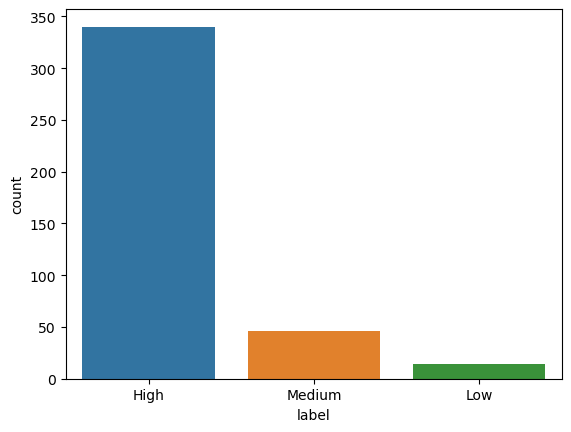

In [29]:
sns.countplot(x = 'label',data = df);

In [30]:
df.head()

,text,complaint_id,stopword_percentage,labels,label
0,I recently opened a Citibank CitiGold Checking...,bc_5,45.806452,High,High
1,I went into Capital One bank to open a checkin...,bc_3,42.465753,High,High
2,I try using my chase card at a bakery departme...,bc_2,43.783784,High,High
3,Approximately a half hour ago I visited a US B...,bc_2,45.853659,High,High
4,I have made a transaction using Chase quickpay...,bc_6,45.000000,High,High


#### On the basis of complaint_ids, entire complaints can be categorized into 4 different Departments

In [31]:
# defining function to segregate complaints according to the departments they belong.

def dept(complaint_id):
    if complaint_id == 'bc_0' or complaint_id == 'bc_1' or complaint_id == 'bc_2' or complaint_id == 'bc_3' or complaint_id == 'bc_4' or complaint_id == 'bc_5' or complaint_id == 'bc_6':
        return 'Department_BC'
    elif complaint_id == 'mc_0' or complaint_id == 'mc_1' or complaint_id == 'mc_2' or complaint_id == 'mc_3' or complaint_id == 'mc_4':
        return 'Department_MC'
    elif complaint_id == 'cc_0' or complaint_id == 'cc_1' or complaint_id == 'cc_2' or complaint_id == 'cc_3' or complaint_id == 'cc_4' or complaint_id == 'cc_5' or complaint_id == 'cc_6' or complaint_id == 'cc_7' or complaint_id == 'cc_8' or complaint_id == 'cc_9' or complaint_id == 'cc_10' or complaint_id == 'cc_11' or complaint_id == 'cc_12' or complaint_id == 'cc_13' or complaint_id == 'cc_14' or complaint_id == 'cc_15':
        return 'Department_CC'
    elif complaint_id == 'lc_0' or complaint_id == 'lc_1' or complaint_id == 'lc_2':
        return 'Department_LC'

In [33]:
df['Department'] = df['complaint_id'].apply(dept)
df.head()

,text,complaint_id,stopword_percentage,labels,label,Department
0,I recently opened a Citibank CitiGold Checking...,bc_5,45.806452,High,High,Department_BC
1,I went into Capital One bank to open a checkin...,bc_3,42.465753,High,High,Department_BC
2,I try using my chase card at a bakery departme...,bc_2,43.783784,High,High,Department_BC
3,Approximately a half hour ago I visited a US B...,bc_2,45.853659,High,High,Department_BC
4,I have made a transaction using Chase quickpay...,bc_6,45.000000,High,High,Department_BC


In [34]:
df['Department'].value_counts()

Department_BC    100
Department_MC    100
Department_CC    100
Department_LC    100
Name: Department, dtype: int64

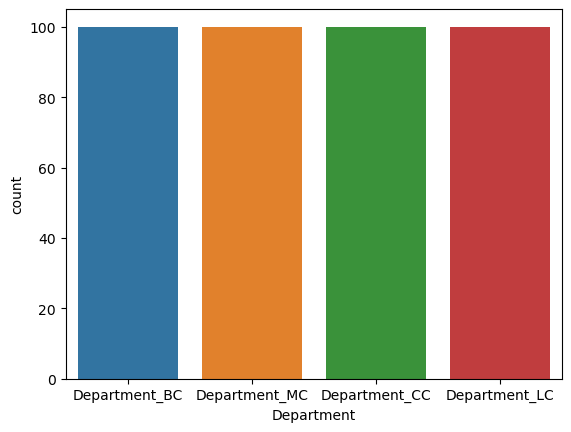

In [35]:
sns.countplot(x = 'Department', data = df);

# Checking to see if data has any taggings

In [36]:
contain_tag = df['text'].str.contains(r'<.*?>')
contain_tag

0      False
1      False
2      False
3      False
4      False
       ...  
395    False
396    False
397    False
398    False
399    False
Name: text, Length: 400, dtype: bool

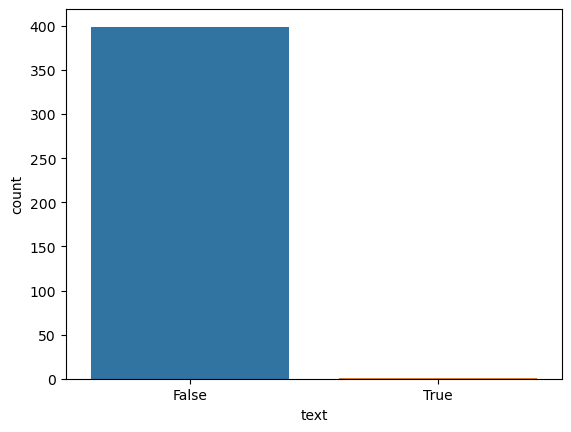

In [38]:
sns.countplot(x = contain_tag);

## Performing Data Cleaning
1. Remove tags, numbers, special charecters from the texts
2. Remove stopwords from the text
3. Conveert text into lower case
4. Apply Lammetization to reduce words to its lemma.

In [39]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [40]:
# to see stop words
#stop_words

In [41]:
len(stop_words)

179

In [42]:
# Importing required Libraries for lemetization
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re
lemmatizer = WordNetLemmatizer()

# Defining function to clean texts
def Clean(raw_data):
    # 1. This will  Delete HTML tags and other special charecter from the text
    data = BeautifulSoup(raw_data, 'html.parser').get_text()
    # 2. This will remove numbers and fills empty space with blank space
    alphabets = re.sub('[^a-zA-Z]', ' ', data)
    # 3.  This will bring all alphabets in the text into lower case
    words = alphabets.lower().split()
    # 5. Stopwords, This will remove all the stopwords from the text
    meaningful_words = [w for w in words if not w in stop_words]
    # 6. lemmitization
    lemmitize_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(lemmitize_words))

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ejaza\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [43]:
df['Clean_Text'] = df['text'].apply(Clean)

In [44]:
df.head()

,text,complaint_id,stopword_percentage,labels,label,Department,Clean_Text
0,I recently opened a Citibank CitiGold Checking...,bc_5,45.806452,High,High,Department_BC,recently opened citibank citigold checking acc...
1,I went into Capital One bank to open a checkin...,bc_3,42.465753,High,High,Department_BC,went capital one bank open checking account si...
2,I try using my chase card at a bakery departme...,bc_2,43.783784,High,High,Department_BC,try using chase card bakery department x ga ch...
3,Approximately a half hour ago I visited a US B...,bc_2,45.853659,High,High,Department_BC,approximately half hour ago visited u bank atm...
4,I have made a transaction using Chase quickpay...,bc_6,45.000000,High,High,Department_BC,made transaction using chase quickpay sent mon...


In [45]:
df['text'][0]

'I recently opened a Citibank CitiGold Checking Account that was advertised to have a signup bonus of   AAdvantage points upon the completion of two consecutive bill payments and {$1000.00} in debit card purchases. After signing up with the intent to complete these requirements a Citibank representative confirmed that the offer applied to my new account and that I should complete the offer requirements. This confirmation was communicated via their online secure message feature, and I have attached a copy for reference. Once I completed the requirements as directed I inquired about the expected delivery date of the earned bonus via secure message and I was told that my account was not targeted and that I would not receive the bonus as promised. This conflicts with what I was previously told and I have already spent a considerable amount of time to meet the requirements as directed. '

In [46]:
df['Clean_Text'][0]

'recently opened citibank citigold checking account advertised signup bonus aadvantage point upon completion two consecutive bill payment debit card purchase signing intent complete requirement citibank representative confirmed offer applied new account complete offer requirement confirmation communicated via online secure message feature attached copy reference completed requirement directed inquired expected delivery date earned bonus via secure message told account targeted would receive bonus promised conflict previously told already spent considerable amount time meet requirement directed'

## Plotting Word Clouds for each departments to visualize most frequent words in complaints related to its departmets

In [47]:
# Creating sub-categories for complaints belonging to their departments
BC=df[(df['Department']=='Department_BC')]
MC=df[(df['Department']=='Department_MC')]
CC=df[(df['Department']=='Department_CC')]
LC=df[(df['Department']=='Department_LC')]

In [48]:
BC.head()

,text,complaint_id,stopword_percentage,labels,label,Department,Clean_Text
0,I recently opened a Citibank CitiGold Checking...,bc_5,45.806452,High,High,Department_BC,recently opened citibank citigold checking acc...
1,I went into Capital One bank to open a checkin...,bc_3,42.465753,High,High,Department_BC,went capital one bank open checking account si...
2,I try using my chase card at a bakery departme...,bc_2,43.783784,High,High,Department_BC,try using chase card bakery department x ga ch...
3,Approximately a half hour ago I visited a US B...,bc_2,45.853659,High,High,Department_BC,approximately half hour ago visited u bank atm...
4,I have made a transaction using Chase quickpay...,bc_6,45.000000,High,High,Department_BC,made transaction using chase quickpay sent mon...


### Word cloud for Departments

##### already installed pip install wordcloud

### Word cloud for Departments_BC

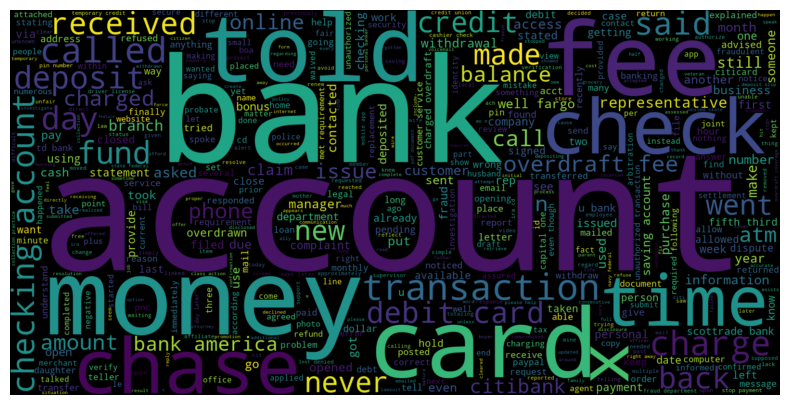

In [49]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 5))
wc = WordCloud(max_words=500, width=1600, height=800).generate(" ".join(BC.Clean_Text))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Word cloud for Departments_MC

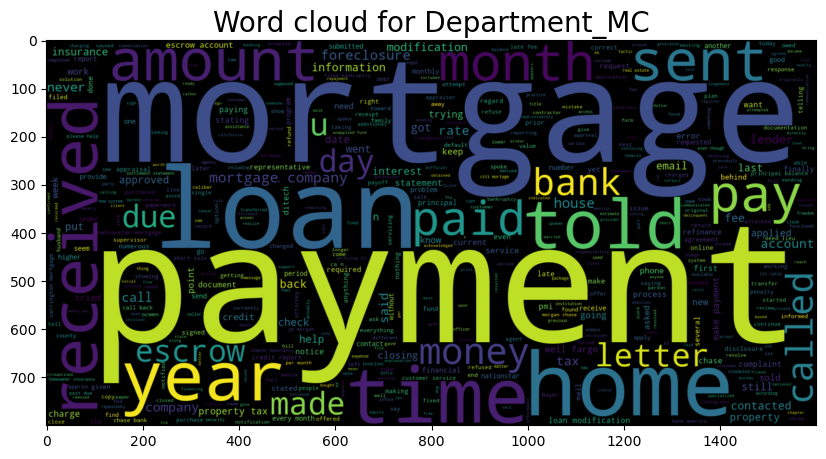

In [50]:
plt.figure(figsize = (30,5))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(MC.Clean_Text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Department_MC',fontsize=20)
plt.show()

#### Word cloud for Department_CC

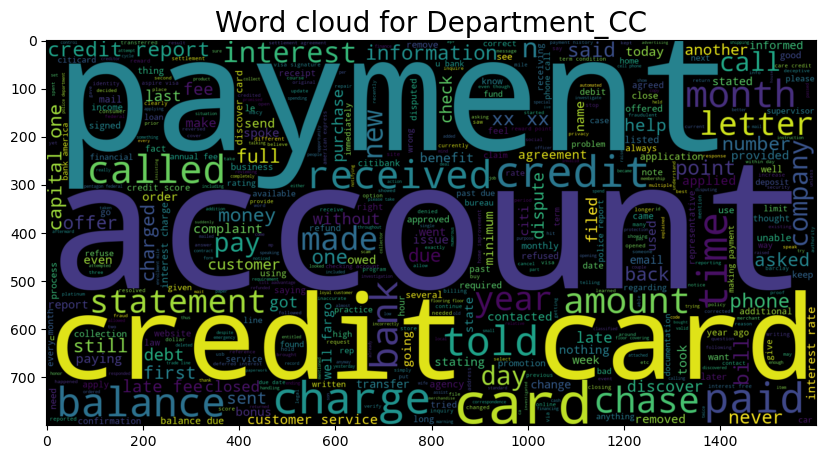

In [51]:
plt.figure(figsize = (30,5))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(CC.Clean_Text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Department_CC',fontsize=20)
plt.show()

#### Word cloud for Department_LC

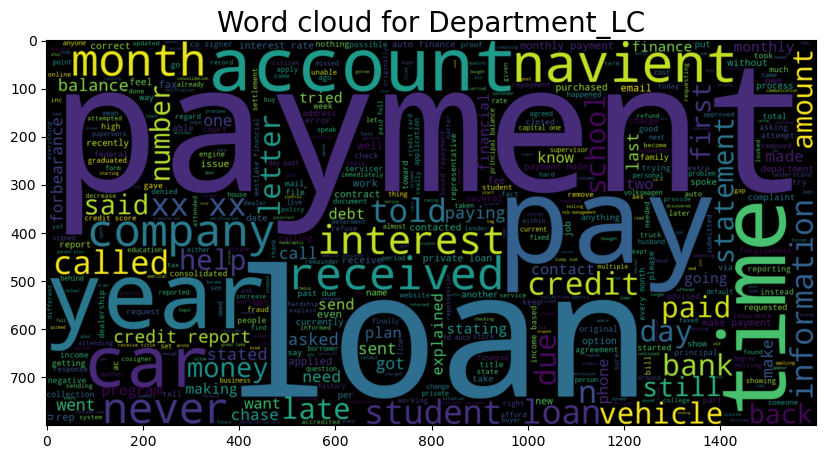

In [52]:
plt.figure(figsize = (30,5))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(LC.Clean_Text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Department_LC',fontsize=20)
plt.show()

### Word Cloud - Bigram 

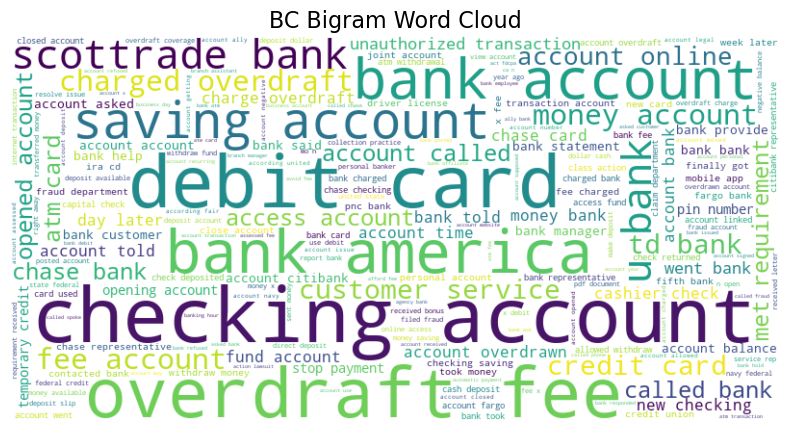

In [53]:
# Example: Assuming BC.Clean_Text is a list of cleaned text data
from sklearn.feature_extraction.text import CountVectorizer
clean_text_data = BC.Clean_Text

# Use CountVectorizer to extract bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', token_pattern=r'\b\w+\b')
bigram_matrix = vectorizer.fit_transform(clean_text_data)

# Get the bigram feature names
feature_names = vectorizer.get_feature_names_out()

# Check if there are any features
if not any(feature_names):
    print("No features found in the text data.")
else:
    # Get the bigram frequencies
    bigram_freq = zip(feature_names, bigram_matrix.sum(axis=0).tolist()[0])

    # Create a dictionary for the bigram frequencies
    bigram_dict = dict(bigram_freq)

    # Generate a bigram word cloud
    wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate_from_frequencies(bigram_dict)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('BC Bigram Word Cloud', fontsize=16)
    plt.show()

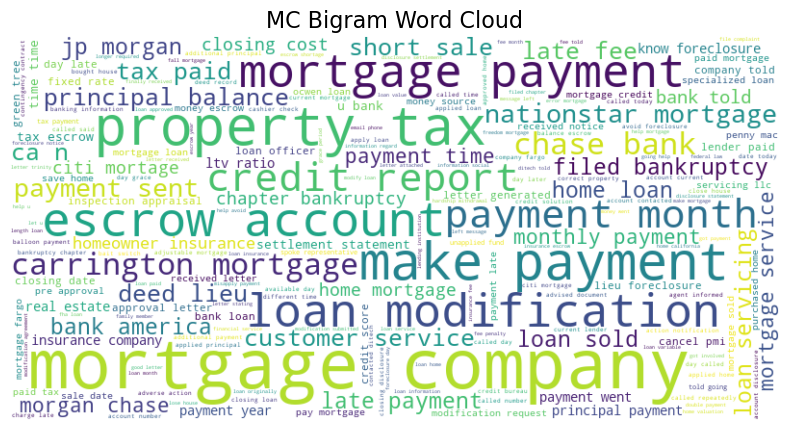

In [54]:
# Example: Assuming MC.Clean_Text is a list of cleaned text data
clean_text_data = MC.Clean_Text

# Use CountVectorizer to extract bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', token_pattern=r'\b\w+\b')
bigram_matrix = vectorizer.fit_transform(clean_text_data)

# Get the bigram feature names
feature_names = vectorizer.get_feature_names_out()

# Check if there are any features
if not any(feature_names):
    print("No features found in the text data.")
else:
    # Get the bigram frequencies
    bigram_freq = zip(feature_names, bigram_matrix.sum(axis=0).tolist()[0])

    # Create a dictionary for the bigram frequencies
    bigram_dict = dict(bigram_freq)

    # Generate a bigram word cloud
    wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate_from_frequencies(bigram_dict)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('MC Bigram Word Cloud', fontsize=16)
    plt.show()

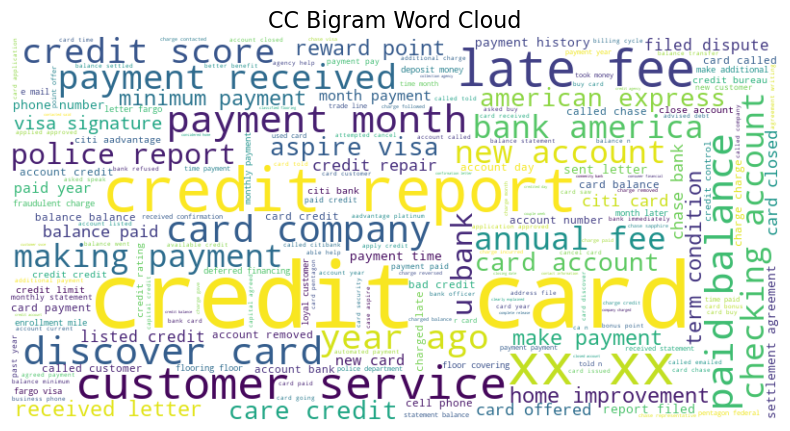

In [55]:
# Example: Assuming CC.Clean_Text is a list of cleaned text data
clean_text_data = CC.Clean_Text

# Use CountVectorizer to extract bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', token_pattern=r'\b\w+\b')
bigram_matrix = vectorizer.fit_transform(clean_text_data)

# Get the bigram feature names
feature_names = vectorizer.get_feature_names_out()

# Check if there are any features
if not any(feature_names):
    print("No features found in the text data.")
else:
    # Get the bigram frequencies
    bigram_freq = zip(feature_names, bigram_matrix.sum(axis=0).tolist()[0])

    # Create a dictionary for the bigram frequencies
    bigram_dict = dict(bigram_freq)

    # Generate a bigram word cloud
    wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate_from_frequencies(bigram_dict)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('CC Bigram Word Cloud', fontsize=16)
    plt.show()

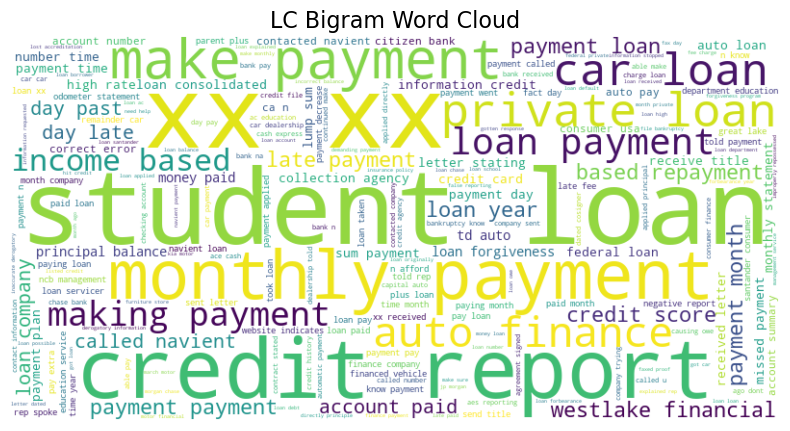

In [56]:
# Example: Assuming BC.Clean_Text is a list of cleaned text data
clean_text_data = LC.Clean_Text

# Use CountVectorizer to extract bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', token_pattern=r'\b\w+\b')
bigram_matrix = vectorizer.fit_transform(clean_text_data)

# Get the bigram feature names
feature_names = vectorizer.get_feature_names_out()

# Check if there are any features
if not any(feature_names):
    print("No features found in the text data.")
else:
    # Get the bigram frequencies
    bigram_freq = zip(feature_names, bigram_matrix.sum(axis=0).tolist()[0])

    # Create a dictionary for the bigram frequencies
    bigram_dict = dict(bigram_freq)

    # Generate a bigram word cloud
    wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate_from_frequencies(bigram_dict)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('LC Bigram Word Cloud', fontsize=16)
    plt.show()

### Q2.Feature Engineering:
#### A. Create a count matrix or a tfidf matrix

TF-IDF stands for Term Frequency Inverse Document Frequency of records. It can be defined as the calculation of how relevant a word in a series or corpus is to a text. The meaning increases proportionally to the number of times in the text a word appears but is compensated by the word frequency in the corpus (data-set).

In [57]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer
count_vectorizer = CountVectorizer()

# Fit and transform the text data
count_matrix = count_vectorizer.fit_transform(df['Clean_Text'])

# Convert the count matrix to a DataFrame
count_df = pd.DataFrame(count_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())

# Display the count matrix
print("Count Matrix:")
print(count_df)

Count Matrix:
     aadvantage  ability  able  abou  abroad  abruptly  absolute  absolutely  \
0             1        0     0     0       0         0         0           0   
1             0        0     1     0       0         0         0           0   
2             0        0     0     0       0         0         0           0   
3             0        0     0     0       0         0         0           0   
4             0        0     0     0       0         0         0           0   
..          ...      ...   ...   ...     ...       ...       ...         ...   
395           0        0     0     0       0         0         0           0   
396           0        0     0     0       0         0         0           0   
397           0        0     0     0       0         0         0           0   
398           0        0     0     0       0         0         0           0   
399           0        0     0     0       0         0         0           0   

     abuse  abusive  ... 

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Clean_Text'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the TF-IDF matrix
print("TF-IDF Matrix:")
print(tfidf_df)


TF-IDF Matrix:
     aadvantage  ability      able  abou  abroad  abruptly  absolute  \
0      0.124048      0.0  0.000000   0.0     0.0       0.0       0.0   
1      0.000000      0.0  0.098317   0.0     0.0       0.0       0.0   
2      0.000000      0.0  0.000000   0.0     0.0       0.0       0.0   
3      0.000000      0.0  0.000000   0.0     0.0       0.0       0.0   
4      0.000000      0.0  0.000000   0.0     0.0       0.0       0.0   
..          ...      ...       ...   ...     ...       ...       ...   
395    0.000000      0.0  0.000000   0.0     0.0       0.0       0.0   
396    0.000000      0.0  0.000000   0.0     0.0       0.0       0.0   
397    0.000000      0.0  0.000000   0.0     0.0       0.0       0.0   
398    0.000000      0.0  0.000000   0.0     0.0       0.0       0.0   
399    0.000000      0.0  0.000000   0.0     0.0       0.0       0.0   

     absolutely  abuse  abusive  ...  yard      year  yes  yesterday  yet  \
0           0.0    0.0      0.0  ...   0.0 

### Can you think of adding any other features apart from count matrix or tfidf matrix?
Sentiment Analysis:

##### Analyze the sentiment of the text using sentiment analysis tools or models.
##### Extract features such as sentiment scores or labels (positive, negative, neutral).

In [59]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

# Assuming df is your DataFrame with a 'text' column containing the text data
# Replace 'text_column' with the actual column name if it's different
text_data = df['Clean_Text']

# Download the VADER lexicon (if not already downloaded)
nltk.download('vader_lexicon')

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each text and create a new column 'sentiment'
df['sentiment'] = text_data.apply(lambda x: sia.polarity_scores(x)['compound'])

# Categorize sentiments as 'positive', 'neutral', or 'negative'
df['sentiment_label'] = pd.cut(df['sentiment'], bins=[-1, -0.1, 0.1, 1], labels=['negative', 'neutral', 'positive'])

# Display the DataFrame with sentiment information
print(df[['Clean_Text', 'sentiment', 'sentiment_label']])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ejaza\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                            Clean_Text  sentiment  \
0    recently opened citibank citigold checking acc...     0.9382   
1    went capital one bank open checking account si...     0.4738   
2    try using chase card bakery department x ga ch...     0.4019   
3    approximately half hour ago visited u bank atm...    -0.7096   
4    made transaction using chase quickpay sent mon...     0.0000   
..                                                 ...        ...   
395  struggling get debt relief entitled private lo...    -0.0258   
396  turn car voluntary repossession licensed auto ...    -0.3818   
397  set payment interest payment one loan paid eve...     0.2023   
398  regard car loan financed first hawaiian bank g...    -0.6083   
399  checked loan one main financial never got inqu...     0.9171   

    sentiment_label  
0          positive  
1          positive  
2          positive  
3          negative  
4           neutral  
..              ...  
395         neutr

In [60]:
df.head()

,text,complaint_id,stopword_percentage,labels,label,Department,Clean_Text,sentiment,sentiment_label
0,I recently opened a Citibank CitiGold Checking...,bc_5,45.806452,High,High,Department_BC,recently opened citibank citigold checking acc...,0.9382,positive
1,I went into Capital One bank to open a checkin...,bc_3,42.465753,High,High,Department_BC,went capital one bank open checking account si...,0.4738,positive
2,I try using my chase card at a bakery departme...,bc_2,43.783784,High,High,Department_BC,try using chase card bakery department x ga ch...,0.4019,positive
3,Approximately a half hour ago I visited a US B...,bc_2,45.853659,High,High,Department_BC,approximately half hour ago visited u bank atm...,-0.7096,negative
4,I have made a transaction using Chase quickpay...,bc_6,45.000000,High,High,Department_BC,made transaction using chase quickpay sent mon...,0.0000,neutral


In [62]:
# pip install --upgrade keras

In [63]:
# pip install keras --upgrade

In [64]:
# pip install transformers --upgrade

In [65]:
# pip install tensorflow --upgrade

In [66]:
# pip install tf-keras

In [61]:
from transformers import pipeline

# Assuming df is your DataFrame with a 'Clean_Text' column containing the text data
text_data = df['Clean_Text']

# Initialize the sentiment analysis pipeline
sentiment_pipeline = pipeline('sentiment-analysis')

# Apply sentiment analysis to each text and create a new column 'sentiment_transformer'
df['sentiment_transformer'] = text_data.apply(lambda x: sentiment_pipeline(x)[0]['label'])

# Display the DataFrame with sentiment information
print(df[['Clean_Text', 'sentiment_transformer']])

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.



                                            Clean_Text sentiment_transformer
0    recently opened citibank citigold checking acc...              NEGATIVE
1    went capital one bank open checking account si...              NEGATIVE
2    try using chase card bakery department x ga ch...              NEGATIVE
3    approximately half hour ago visited u bank atm...              NEGATIVE
4    made transaction using chase quickpay sent mon...              NEGATIVE
..                                                 ...                   ...
395  struggling get debt relief entitled private lo...              NEGATIVE
396  turn car voluntary repossession licensed auto ...              NEGATIVE
397  set payment interest payment one loan paid eve...              NEGATIVE
398  regard car loan financed first hawaiian bank g...              NEGATIVE
399  checked loan one main financial never got inqu...              NEGATIVE

[400 rows x 2 columns]


In [67]:
# pip install pipdeptree

In [68]:
df.head()

,text,complaint_id,stopword_percentage,labels,label,Department,Clean_Text,sentiment,sentiment_label,sentiment_transformer
0,I recently opened a Citibank CitiGold Checking...,bc_5,45.806452,High,High,Department_BC,recently opened citibank citigold checking acc...,0.9382,positive,NEGATIVE
1,I went into Capital One bank to open a checkin...,bc_3,42.465753,High,High,Department_BC,went capital one bank open checking account si...,0.4738,positive,NEGATIVE
2,I try using my chase card at a bakery departme...,bc_2,43.783784,High,High,Department_BC,try using chase card bakery department x ga ch...,0.4019,positive,NEGATIVE
3,Approximately a half hour ago I visited a US B...,bc_2,45.853659,High,High,Department_BC,approximately half hour ago visited u bank atm...,-0.7096,negative,NEGATIVE
4,I have made a transaction using Chase quickpay...,bc_6,45.000000,High,High,Department_BC,made transaction using chase quickpay sent mon...,0.0000,neutral,NEGATIVE


In [69]:
# Assuming df is your DataFrame and 'column_name' is the column for which you want value counts
value_counts = df['sentiment_transformer'].value_counts()

# Print or use the value counts as needed
print(value_counts)


NEGATIVE    394
POSITIVE      6
Name: sentiment_transformer, dtype: int64


In [70]:
value_counts = df['sentiment_label'].value_counts()
print(value_counts)

positive    239
negative    132
neutral      29
Name: sentiment_label, dtype: int64


## Q2.Feature Engineering:
Create features based on pre-trained word vectors or features out of a BERT model (optional)

# Using Pre-trained Word Vectors (Word2Vec):

BERT, stands for Bidirectional Encoder Representations from Transformers, is a natural language processing (NLP) model developed by Google. It was introduced in a research paper titled "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding," published by researchers at Google AI in 2018.

In [71]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np

# Assuming df is your DataFrame with a 'text_column' containing the text data
text_data = df['Clean_Text']

# Tokenize the text and train a Word2Vec model
tokenized_text = [word_tokenize(text.lower()) for text in text_data]
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

# Function to average word vectors for a text
def average_word_vectors(text, model, num_features):
    words = word_tokenize(text.lower())
    feature_vector = np.zeros((num_features,), dtype="float32")
    n_words = 0
    for word in words:
        if word in model.wv.key_to_index:
            index = model.wv.key_to_index[word]
            feature_vector = np.add(feature_vector, model.wv.vectors[index])
            n_words += 1
    if n_words > 0:
        feature_vector = np.divide(feature_vector, n_words)
    return feature_vector

# Apply the function to each text and create a new column 'word2vec_features'
num_features = 100  # Adjust based on the dimensionality of your Word2Vec model
df['word2vec_features'] = text_data.apply(lambda x: average_word_vectors(x, word2vec_model, num_features))

# Display the DataFrame with the new features
print(df[['Clean_Text', 'word2vec_features']])


                                            Clean_Text  \
0    recently opened citibank citigold checking acc...   
1    went capital one bank open checking account si...   
2    try using chase card bakery department x ga ch...   
3    approximately half hour ago visited u bank atm...   
4    made transaction using chase quickpay sent mon...   
..                                                 ...   
395  struggling get debt relief entitled private lo...   
396  turn car voluntary repossession licensed auto ...   
397  set payment interest payment one loan paid eve...   
398  regard car loan financed first hawaiian bank g...   
399  checked loan one main financial never got inqu...   

                                     word2vec_features  
0    [-0.09194748, 0.1960356, -0.06328238, -0.04187...  
1    [-0.13055879, 0.2818532, -0.09152718, -0.05922...  
2    [-0.14314924, 0.30504182, -0.097400635, -0.066...  
3    [-0.111926176, 0.24520506, -0.08068007, -0.054...  
4    [-0.12361626,

In [72]:
df.head()

,text,complaint_id,stopword_percentage,labels,label,Department,Clean_Text,sentiment,sentiment_label,sentiment_transformer,word2vec_features
0,I recently opened a Citibank CitiGold Checking...,bc_5,45.806452,High,High,Department_BC,recently opened citibank citigold checking acc...,0.9382,positive,NEGATIVE,"[-0.09194748, 0.1960356, -0.06328238, -0.04187..."
1,I went into Capital One bank to open a checkin...,bc_3,42.465753,High,High,Department_BC,went capital one bank open checking account si...,0.4738,positive,NEGATIVE,"[-0.13055879, 0.2818532, -0.09152718, -0.05922..."
2,I try using my chase card at a bakery departme...,bc_2,43.783784,High,High,Department_BC,try using chase card bakery department x ga ch...,0.4019,positive,NEGATIVE,"[-0.14314924, 0.30504182, -0.097400635, -0.066..."
3,Approximately a half hour ago I visited a US B...,bc_2,45.853659,High,High,Department_BC,approximately half hour ago visited u bank atm...,-0.7096,negative,NEGATIVE,"[-0.111926176, 0.24520506, -0.08068007, -0.054..."
4,I have made a transaction using Chase quickpay...,bc_6,45.000000,High,High,Department_BC,made transaction using chase quickpay sent mon...,0.0000,neutral,NEGATIVE,"[-0.12361626, 0.2678529, -0.087215416, -0.0573..."


# Modelling:
o	What models can you use to create a ticket classification system?

The choice of model depends on various factors such as the size and complexity of the dataset, computational resources, and the desired level of accuracy. It's often a good idea to start with simpler models (e.g., Naive Bayes or SVM) and then explore more complex models if needed. Additionally, techniques like feature engineering, hyperparameter tuning, and model ensembling can further enhance the performance of the classification system.

### Gaussian Naive Bayes classifier

In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Encode the labels to numerical values
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['Department'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['word2vec_features'].tolist(), df['encoded_label'], test_size=0.2, random_state=42)

# Initialize the Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test)

# Decode the predicted labels back to original labels
predicted_labels = label_encoder.inverse_transform(y_pred)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', report)


Accuracy: 0.24
Classification Report:
               precision    recall  f1-score   support

           0       0.16      0.19      0.17        26
           1       0.26      0.33      0.29        18
           2       0.00      0.00      0.00        18
           3       0.32      0.44      0.37        18

    accuracy                           0.24        80
   macro avg       0.18      0.24      0.21        80
weighted avg       0.18      0.24      0.21        80



### SVM

In [74]:

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Encode the labels to numerical values
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['Department'])
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['word2vec_features'].tolist(), df['encoded_label'], test_size=0.2, random_state=42)

# Initialize the SVM classifier
svm_classifier = SVC()

# Train the classifier
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Decode the predicted labels back to original labels
predicted_labels = label_encoder.inverse_transform(y_pred)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', report)

Accuracy: 0.29
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.25      0.39      0.30        18
           2       0.31      0.61      0.42        18
           3       0.29      0.28      0.29        18

    accuracy                           0.29        80
   macro avg       0.21      0.32      0.25        80
weighted avg       0.19      0.29      0.23        80



# Conclusion: 
Model 1 appears to be better than Model 2 in terms of overall performance. However, both models ahave room for improvement

## k-Nearest Neighbors (KNN)

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Assuming 'word2vec_features' is a column containing lists or arrays
df['word2vec_features'] = df['word2vec_features'].apply(lambda x: pd.Series(x) if isinstance(x, list) else pd.Series([x]))

# Create DataFrame with columns for each element in the lists
X = pd.DataFrame(df['word2vec_features'].tolist())

# Fill missing values with zeros or any other suitable strategy
X = X.fillna(0)

# Assuming 'sentiment_label' is your target variable
y = df['Department']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a k-Nearest Neighbors Classifier
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# Train the model on the training set
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_rep)

Accuracy: 0.34
Classification Report:
               precision    recall  f1-score   support

Department_BC       0.41      0.42      0.42        26
Department_CC       0.30      0.39      0.34        18
Department_LC       0.24      0.22      0.23        18
Department_MC       0.38      0.28      0.32        18

     accuracy                           0.34        80
    macro avg       0.33      0.33      0.33        80
 weighted avg       0.34      0.34      0.34        80



In [ ]:
# pip install tensorflow pandas numpy

### LSTM (Long Short-Term Memory)

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture that is well-suited for sequence prediction tasks, particularly those involving long-term dependencies. Unlike traditional RNNs, LSTM networks are designed to address the vanishing gradient problem, which occurs when training RNNs on long sequences, leading to difficulties in learning long-term dependencies.

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# 'text' is the column containing text data
texts = df['text'].tolist()
labels = df['Department'].tolist()

# Encode labels into numerical format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences to have the same length
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

# Build the LSTM model
embedding_dim = 50  # Adjust based on your requirements
vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))  # Remove input_length
model.add(LSTM(units=100))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

# Evaluate the model
accuracy = model.evaluate(X_test, y_test)[1]

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_rep)


Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 321ms/step - accuracy: 0.2479 - loss: 0.5358 - val_accuracy: 0.2031 - val_loss: -0.0801
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.2906 - loss: -0.5552 - val_accuracy: 0.2031 - val_loss: -1.8522
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.2604 - loss: -2.5306 - val_accuracy: 0.2031 - val_loss: -3.0692
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.2604 - loss: -4.3316 - val_accuracy: 0.2031 - val_loss: -3.8110
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.2688 - loss: -4.8925 - val_accuracy: 0.2031 - val_loss: -4.4958
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2375 - loss: -2.9847
Test Accuracy: 22.50%
Classification Report:
               precision    recall  f1-score   support

Department_BC       0.41      0.42      0.42        26
Department_CC       0.30      0.39      0.34        18
Department_LC       0.24      0.22      0.23        18
Department_MC       0.38   

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['Department'], test_size=0.2, random_state=42)

# Encode labels into numerical format
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have the same length
max_length = 100  # Adjust based on your requirements
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post')

# Build the LSTM model
embedding_dim = 100  # Adjust based on your requirements
vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))  # Bidirectional LSTM layer
model.add(Dropout(0.2))  # Add dropout layer to prevent overfitting
model.add(Bidirectional(LSTM(units=64)))  # Another bidirectional LSTM layer
model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))  # Output layer with softmax activation for multiclass classification

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_padded, encoded_y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model
accuracy = model.evaluate(X_test_padded, encoded_y_test)[1]

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_rep)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 545ms/step - accuracy: 0.2562 - loss: 1.3865 - val_accuracy: 0.2188 - val_loss: 1.3939
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.4099 - loss: 1.3699 - val_accuracy: 0.2812 - val_loss: 1.4019
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - accuracy: 0.4276 - loss: 1.3544 - val_accuracy: 0.2812 - val_loss: 1.4040
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.5063 - loss: 1.2837 - val_accuracy: 0.4219 - val_loss: 1.3364
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - accuracy: 0.5672 - loss: 1.0780 - val_accuracy: 0.4219 - val_loss: 1.2583
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step - accuracy: 0.5708 - loss: 0.9258 - val_accuracy: 0.4531 - val_loss: 1.1936
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - accuracy: 0.7323 - loss: 0.7620 - val_accuracy: 0.5469 - val_loss: 1.0483
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.8880 - loss: 0.5246 - val_accuracy: 0.6250 - val_loss:

#####  NOTES
This code implements the following improvements:

1. Bidirectional LSTM: Stacking LSTM layers with return_sequences=True and Dropout layers to prevent overfitting.
2. Adjusting Embedding Dimensions: Increased embedding dimensions to 100 for richer representations.
3. Hyperparameter Tuning: Experiment with different hyperparameters such as LSTM units, embedding dimensions, and dropout rates to find optimal values.
4. Loss Function: Using sparse_categorical_crossentropy as the loss function for multiclass classification.
5. Evaluation: Evaluating the model's accuracy on the test set after training.
6. We can further experiment with different hyperparameters, architectures, and preprocessing techniques to improve the model's performance.

# Random Forest

In [79]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['Department'], test_size=0.2, random_state=42)

# Initialize a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', report)

Accuracy: 0.86
Classification Report:
                precision    recall  f1-score   support

Department_BC       0.92      0.88      0.90        26
Department_CC       0.71      0.83      0.77        18
Department_LC       0.94      0.83      0.88        18
Department_MC       0.89      0.89      0.89        18

     accuracy                           0.86        80
    macro avg       0.87      0.86      0.86        80
 weighted avg       0.87      0.86      0.86        80



In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['Depar  tment'], test_size=0.2, random_state=42)

# Initialize a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Train the model with the best parameters
best_estimator.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = best_estimator.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print("Best Parameters:", best_params)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', report)


Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.86
Classification Report:
                precision    recall  f1-score   support

Department_BC       0.88      0.88      0.88        26
Department_CC       0.78      0.78      0.78        18
Department_LC       0.85      0.94      0.89        18
Department_MC       0.94      0.83      0.88        18

     accuracy                           0.86        80
    macro avg       0.86      0.86      0.86        80
 weighted avg       0.86      0.86      0.86        80



Overall, it seems like the model is performing well on this dataset with the selected hyperparameters.

#### Using BERT (Bidirectional Encoder Representations from Transformers)

In [85]:
pip install transformers torch tqdm

Note: you may need to restart the kernel to use updated packages.


In [97]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch
from tqdm import tqdm

# Assuming 'text' is the column containing your text data
texts = df['text'].tolist()
labels = df['Department'].tolist()

# Encode labels into numerical format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, encoded_labels, test_size=0.2, random_state=42)

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Tokenize and pad the input sequences
train_encodings = tokenizer(X_train, truncation=True, padding=True, return_tensors='pt', max_length=128)
test_encodings = tokenizer(X_test, truncation=True, padding=True, return_tensors='pt', max_length=128)

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Set up optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

# Train the BERT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_loader)
    print(f'Training Loss: {average_loss:.4f}')

# Evaluate the BERT model on the test set
model.eval()
all_predictions = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating'):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_predictions.extend(predictions)

# Decode numerical labels back to original labels
y_test_decoded = label_encoder.inverse_transform(y_test)
predicted_labels = label_encoder.inverse_transform(all_predictions)

# Evaluate the BERT model
accuracy = accuracy_score(y_test, all_predictions)
classification_rep = classification_report(y_test_decoded, predicted_labels)
 
# Print the results
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_rep)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3: 100%|██████████| 20/20 [2:42:13<00:00, 486.68s/it]  


Training Loss: 1.2883


Epoch 2/3: 100%|██████████| 20/20 [2:44:58<00:00, 494.93s/it]  


Training Loss: 0.6164


Epoch 3/3: 100%|██████████| 20/20 [2:37:32<00:00, 472.61s/it]  


Training Loss: 0.2608


Evaluating: 100%|██████████| 5/5 [19:23<00:00, 232.77s/it]

Test Accuracy: 86.25%
Classification Report:
               precision    recall  f1-score   support

Department_BC       0.91      0.77      0.83        26
Department_CC       0.68      0.72      0.70        18
Department_LC       0.86      1.00      0.92        18
Department_MC       1.00      1.00      1.00        18

     accuracy                           0.86        80
    macro avg       0.86      0.87      0.86        80
 weighted avg       0.87      0.86      0.86        80



###
In summary, the model performs relatively well in identifying 'positive' instances, but struggles with both 'negative' and 'neutral' instances, particularly with 'neutral' where it fails to correctly classify any instances. The overall performance could likely be improved, especially in terms of recall and precision for all classes.

## Will an unsupervised technique such as clustering work here?

In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Assuming 'text_column' is the name of the column containing your text data
text_data = df['Clean_Text']

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

# Convert the TF-IDF matrix to a DataFrame for better readability
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the TF-IDF DataFrame
print(tfidf_df)

     aadvantage  ability      able  abou  abroad  abruptly  absolute  \
0      0.124048      0.0  0.000000   0.0     0.0       0.0       0.0   
1      0.000000      0.0  0.098317   0.0     0.0       0.0       0.0   
2      0.000000      0.0  0.000000   0.0     0.0       0.0       0.0   
3      0.000000      0.0  0.000000   0.0     0.0       0.0       0.0   
4      0.000000      0.0  0.000000   0.0     0.0       0.0       0.0   
..          ...      ...       ...   ...     ...       ...       ...   
395    0.000000      0.0  0.000000   0.0     0.0       0.0       0.0   
396    0.000000      0.0  0.000000   0.0     0.0       0.0       0.0   
397    0.000000      0.0  0.000000   0.0     0.0       0.0       0.0   
398    0.000000      0.0  0.000000   0.0     0.0       0.0       0.0   
399    0.000000      0.0  0.000000   0.0     0.0       0.0       0.0   

     absolutely  abuse  abusive  ...  yard      year  yes  yesterday  yet  \
0           0.0    0.0      0.0  ...   0.0  0.000000  0.0 

In [87]:
from sklearn.cluster import KMeans
# Assuming your text data is in the 'Clean_Text' column
text_data = df['Clean_Text']

# Specify the number of clusters (you can adjust this based on your requirements)
num_clusters = 4

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(tfidf_matrix)

# Add the cluster labels to your DataFrame
df['cluster'] = clusters

# Display the DataFrame with cluster information
print(df[['Clean_Text', 'cluster']])

                                            Clean_Text  cluster
0    recently opened citibank citigold checking acc...        3
1    went capital one bank open checking account si...        2
2    try using chase card bakery department x ga ch...        3
3    approximately half hour ago visited u bank atm...        3
4    made transaction using chase quickpay sent mon...        3
..                                                 ...      ...
395  struggling get debt relief entitled private lo...        1
396  turn car voluntary repossession licensed auto ...        1
397  set payment interest payment one loan paid eve...        0
398  regard car loan financed first hawaiian bank g...        0
399  checked loan one main financial never got inqu...        3

[400 rows x 2 columns]


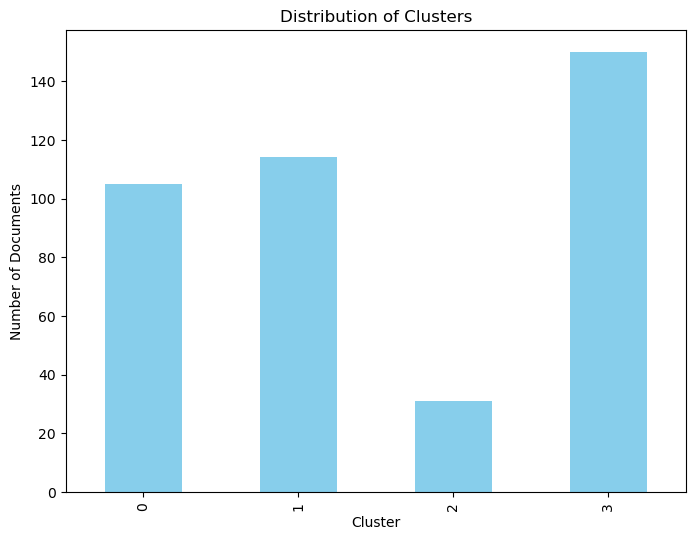

In [88]:
import matplotlib.pyplot as plt

# Plot the distribution of clusters
plt.figure(figsize=(8, 6))
df['cluster'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Documents')
plt.show()

In [89]:
from sklearn.metrics import silhouette_score

# Evaluate silhouette score
silhouette_avg = silhouette_score(tfidf_matrix, df['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.00895495542286217


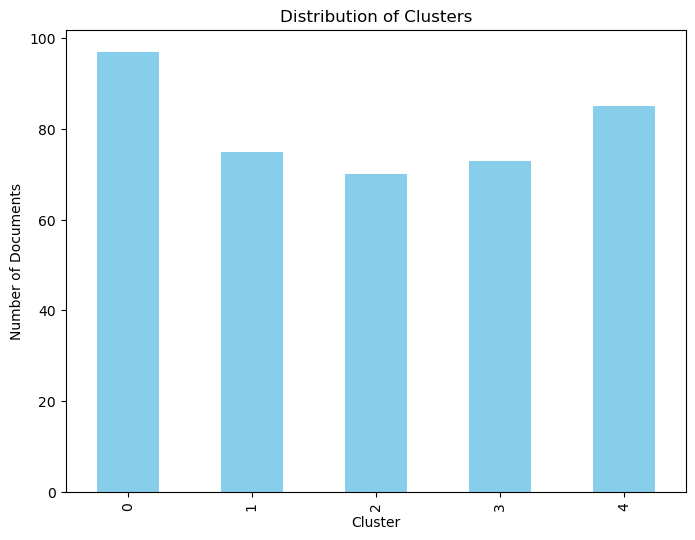

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'Clean_Text' is the column containing cleaned text data
text_data = df['Clean_Text']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(text_data)

# Apply K-means clustering
num_clusters = 5  # Adjust the number of clusters based on your requirements
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Visualize the distribution of clusters
plt.figure(figsize=(8, 6))
df['cluster'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Documents')
plt.show()

In [91]:
df.head()

,text,complaint_id,stopword_percentage,labels,label,Department,Clean_Text,sentiment,sentiment_label,sentiment_transformer,word2vec_features,encoded_label,cluster
0,I recently opened a Citibank CitiGold Checking...,bc_5,45.806452,High,High,Department_BC,recently opened citibank citigold checking acc...,0.9382,positive,NEGATIVE,"[-0.09194748, 0.1960356, -0.06328238, -0.04187...",0,4
1,I went into Capital One bank to open a checkin...,bc_3,42.465753,High,High,Department_BC,went capital one bank open checking account si...,0.4738,positive,NEGATIVE,"[-0.13055879, 0.2818532, -0.09152718, -0.05922...",0,4
2,I try using my chase card at a bakery departme...,bc_2,43.783784,High,High,Department_BC,try using chase card bakery department x ga ch...,0.4019,positive,NEGATIVE,"[-0.14314924, 0.30504182, -0.097400635, -0.066...",0,3
3,Approximately a half hour ago I visited a US B...,bc_2,45.853659,High,High,Department_BC,approximately half hour ago visited u bank atm...,-0.7096,negative,NEGATIVE,"[-0.111926176, 0.24520506, -0.08068007, -0.054...",0,3
4,I have made a transaction using Chase quickpay...,bc_6,45.000000,High,High,Department_BC,made transaction using chase quickpay sent mon...,0.0000,neutral,NEGATIVE,"[-0.12361626, 0.2678529, -0.087215416, -0.0573...",0,3


In [92]:
from sklearn.metrics import silhouette_score

# Evaluate silhouette score
silhouette_avg = silhouette_score(tfidf_matrix, df['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.014799264355072853


In [93]:
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

# Assuming df is your DataFrame with a 'Clean_Text' column containing the text data
text_data = df['Clean_Text']

# Convert text data to TF-IDF vectors
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(text_data)

# Experiment with different values for eps and min_samples
eps_values = [0.5, 1.0, 1.5]
min_samples_values = [5, 10, 15]

best_silhouette_score = -1
best_eps = None
best_min_samples = None
best_cluster_labels = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(tfidf_matrix)
        
        # Check if more than one cluster is formed
        unique_labels = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        if unique_labels > 1:
            silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
            
            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_eps = eps
                best_min_samples = min_samples
                best_cluster_labels = cluster_labels

# Print the best parameters
print(f"Best Silhouette Score: {best_silhouette_score}")
print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")

# Add cluster labels to DataFrame
df['cluster_label_dbscan'] = best_cluster_labels

# Display the DataFrame with cluster labels
print(df[['Clean_Text', 'cluster_label_dbscan']])

Best Silhouette Score: -1
Best eps: None
Best min_samples: None
                                            Clean_Text cluster_label_dbscan
0    recently opened citibank citigold checking acc...                 None
1    went capital one bank open checking account si...                 None
2    try using chase card bakery department x ga ch...                 None
3    approximately half hour ago visited u bank atm...                 None
4    made transaction using chase quickpay sent mon...                 None
..                                                 ...                  ...
395  struggling get debt relief entitled private lo...                 None
396  turn car voluntary repossession licensed auto ...                 None
397  set payment interest payment one loan paid eve...                 None
398  regard car loan financed first hawaiian bank g...                 None
399  checked loan one main financial never got inqu...                 None

[400 rows x 2 columns]


In [94]:
from sklearn.cluster import KMeans

# Assuming df is your DataFrame with a 'Clean_Text' column containing the text data
text_data = df['Clean_Text']

# Convert text data to TF-IDF vectors
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(text_data)

# Experiment with different values for the number of clusters (n_clusters)
n_clusters_values = [2, 3, 4]

best_silhouette_score_kmeans = -1
best_n_clusters = None
best_kmeans_labels = None

for n_clusters in n_clusters_values:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(tfidf_matrix)
    
    silhouette_avg_kmeans = silhouette_score(tfidf_matrix, kmeans_labels)
    
    if silhouette_avg_kmeans > best_silhouette_score_kmeans:
        best_silhouette_score_kmeans = silhouette_avg_kmeans
        best_n_clusters = n_clusters
        best_kmeans_labels = kmeans_labels

# Print the best parameters for K-means
print(f"Best Silhouette Score (K-means): {best_silhouette_score_kmeans}")
print(f"Best n_clusters (K-means): {best_n_clusters}")

# Add cluster labels to DataFrame
df['cluster_label_kmeans'] = best_kmeans_labels

# Display the DataFrame with K-means cluster labels
print(df[['Clean_Text', 'cluster_label_kmeans']])

Best Silhouette Score (K-means): 0.011748149575539815
Best n_clusters (K-means): 2
                                            Clean_Text  cluster_label_kmeans
0    recently opened citibank citigold checking acc...                     0
1    went capital one bank open checking account si...                     0
2    try using chase card bakery department x ga ch...                     0
3    approximately half hour ago visited u bank atm...                     0
4    made transaction using chase quickpay sent mon...                     0
..                                                 ...                   ...
395  struggling get debt relief entitled private lo...                     1
396  turn car voluntary repossession licensed auto ...                     1
397  set payment interest payment one loan paid eve...                     1
398  regard car loan financed first hawaiian bank g...                     1
399  checked loan one main financial never got inqu...                

#### 
Overall, the low Silhouette Score and the choice of only two clusters imply that the data may not have clear, well-defined clusters, or that K-means might not be the most suitable clustering algorithm for this particular dataset. It might be worth exploring other clustering algorithms or preprocessing techniques to better understand the underlying structure of the data.